# Machine Learning with the Open Data Cube <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)
* **Special requirements:** A shapefile of labelled data is required to use this notebook
* **Prerequisites:** A basic understanding of supervised learning techniques is required. [Introduction to statistical learning](https://doi.org/10.1007/978-1-4614-7138-7) is a useful resource to begin with - it can be downloaded for free [here](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf). The [Scikit-learn](https://scikit-learn.org/stable/supervised_learning.html) documentation provides information on the available models and their parameters.


## Description

This notebook demonstrates a potential workflow using [dea_classificationtools](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Scripts/dea_classificationtools.py) to implement a supervised learning landcover classifier within the ODC (Open Data Cube) framework. 

This example predicts a single class of cultivated / agricultural area.

The model training process is one of experimentation and assumption checking that occurs in an iterative cycle. 

For larger model training and prediction implementations this notebook can be adapted into a python file and run in a distributed fashion.

>**Before using this notebook for your own purposes you must have labelled data in the shapefile format. An example dataset is provided.**

1. Extract the desired ODC data for each labelled area (This becomes our training dataset).
2. Train a model, adjust parameters. 
3. Predict landcover using trained model on new data

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import shapely
import rasterio
import geopandas as gpd
from datacube import helpers
from datacube.utils import geometry
from IPython.display import Image
import pydotplus
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO
from sklearn import tree
from sklearn import model_selection
import numpy
import os
import xarray as xr
import numpy as np
import datacube
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../Scripts')
from dea_plotting import map_shapefile
from dea_classificationtools import get_training_data_for_shp, predict_xr

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [2]:
dc = datacube.Datacube(app='Machine_learning_with_ODC')

### Analysis parameters
* `path`: The path to the input shapefile
* `field`: This is the name of column in your shapefile attribute table that contains the class labels
* `product`: The name of the product to extract. This method works on DEA Landsat Collection 3 ARD Landsat 7 and Landsat 8 data - [ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)
 is a good start.
* `year`: The year you wish to extract data for, typically the same year the labels were created
* `feature_stats`: This is an option to calculate the mean of the values within the feature, it is useful for reducing noise and simplifying the training data

In [3]:
path = '../Supplementary_data/Machine_learning_with_ODC/Cell_-16_-39_2015.shp'
field = 'classnum'
product = 'ls8_nbart_geomedian_annual'
year = 2015
feature_stats = 'mean'

In [4]:
cmap = matplotlib.colors.ListedColormap(["#4ca334"])
map_shapefile(gpd.read_file(path), colormap=cmap, hover_col ='classnum')

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Label(value='')

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

## Extract training data using a shapefile

This function takes a shapefile that contains class labels and extracts the specified product within these areas into a single array

> The following cell can take several minutes to run

> The class labels will be contained in the first column of the output array

In [5]:
# Empty list which we will populate with data
out = []

# Calling the extraction function
column_names = get_training_data_for_shp(path, out,
                                         product=product,
                                         time=('{}-01-01'.format(year),
                                               '{}-12-31'.format(year)),
                                         crs='EPSG:3577', field=field,
                                         calc_indices=None,
                                         feature_stats=feature_stats)

# Stacking the extracted training data for each feature into a single array
model_input = np.vstack(out)
print(model_input.shape)

Loading data...
Rasterizing features and extracting data...
(217, 7) 0217/0217


## Preprocessing

`Scitkit-learn` models cannot accept training data with `NaNs` (Not a Number). This preprocessing step removes any potential rows in the training array with NaNs

In [6]:
# Remove any potential nans
model_input = model_input[~numpy.isnan(model_input).any(axis=1)]
print("Cleaned input shape:", model_input.shape)

Cleaned input shape: (217, 7)


Our training data has multiple classes in it however we are only trying to predict one class with this model, therefore we change the label value for every training row that isn't for the class we are interested in to 0.

These entries provide counterexamples to help the model distinguish the landcover classes from each other.

In [7]:
# Modify the input training data for single class labels
model_input[:,0] = np.where(model_input[:,0] == 111, 1, 0)

Split data into training and testing data. 80 % is used for training with 20 % held back for testing.

We stratify the training data by the distributions of class membership, this sampling method leads to a similar distribution of class membership in the training data.

In [8]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(model_input, stratify=model_input[:, 0],
                                                           train_size=0.8, random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (173, 7)
Test shape: (44, 7)


## Model preparation

This section automatically creates a list of names and their respective indices for each of the training data variables

In [9]:
# Extract the variable names and relevant indices from the processed shapefile
model_variables = column_names[1:]

column_names_indices = {}

for col_num, var_name in enumerate(column_names):
    column_names_indices[var_name] = col_num

model_col_indices = []

for model_var in model_variables:
    model_col_indices.append(column_names_indices[model_var])
    
print(column_names_indices)

{'classnum': 0, 'blue': 1, 'green': 2, 'red': 3, 'nir': 4, 'swir1': 5, 'swir2': 6}


A decision tree model is chosen as it is one of the simplest supervised machine learning models we can implement. 

Its strength's are its explainability and cheap computational cost.

In [10]:
# Initialise model
model = tree.DecisionTreeClassifier()

## Train model

The model is fitted / trained using the prepared training data. 

The fitting process uses the decision tree approach to create a generalised representation of reality based on the training data. 

This fitted / trained model can then be used to predict which class new data belongs to.

In [11]:
# Train model
model.fit(model_train[:,model_col_indices], model_train[:,0])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# Analyse results

## Feature importance

The decision tree classifier allows us to inspect the feature importance of each input variable.

Feature importance represents the relative contribution of each variable in predicting the desired landcover class, when summed they add up to 1.0.

In [12]:
# This shows the feature importance of the input features for predicting the class labels provided
print(dict(zip(model_variables, model.feature_importances_)))

{'blue': 0.0, 'green': 0.9590484080956326, 'red': 0.0, 'nir': 0.0, 'swir1': 0.04095159190436738, 'swir2': 0.0}


In [13]:
# Prepare a dictionary of class names
class_names = {1: 'Cultivated Terrestrial Vegetated',
               0: 'Not Cultivated Terrestrial Vegetated'}

This decision tree representation visualises the trained model. Here we can see that the model decides which landcover class to assign based on the value of the `swir1` and `green` variables.

The gini value shown in the tree represents the decrease in node impurity this can also be understood as how heterogeneous the labels are. 

This metric is used by the decision tree to determine how to split the data into smaller groups.

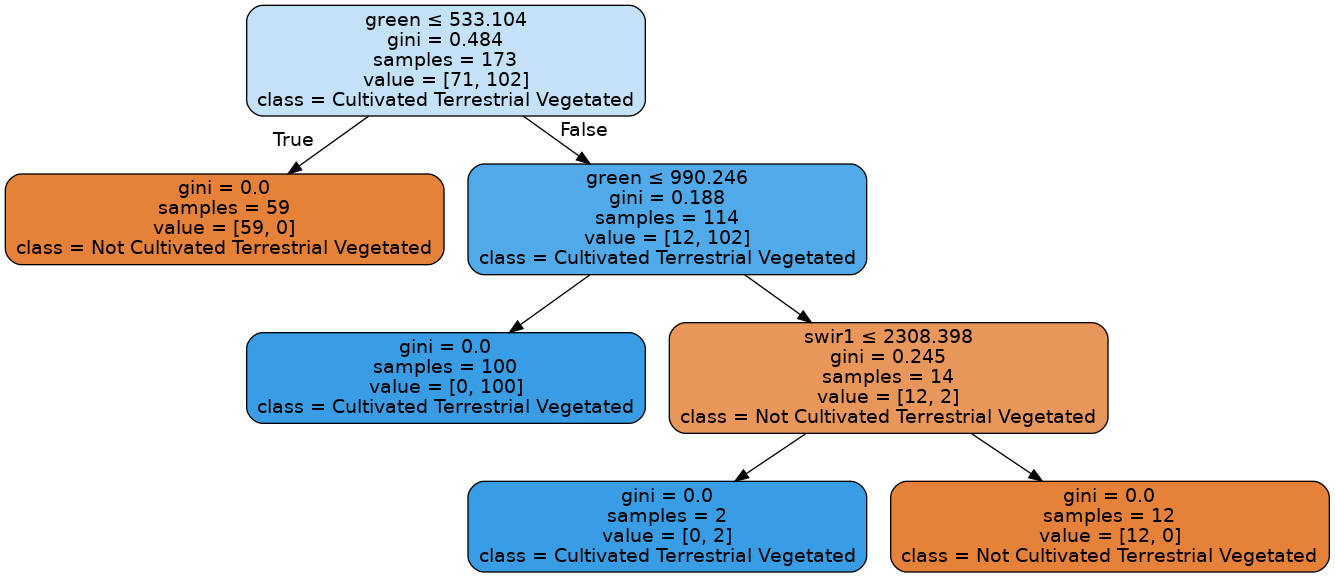

In [14]:
# Plot decision tree
class_codes = numpy.unique(model_train[:, 0])

class_names_in_model = list({k: class_names[k] for k in class_codes}.values())

dot_data = StringIO()

tree.export_graphviz(model, out_file=dot_data, feature_names=model_variables, class_names=class_names_in_model,
                     filled=True, rounded=True,
                     special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


## Accuracy

Using the test data we partitioned off before we can test the accuracy of the trained model on this new, "unseen" data.

An accuracy value of 1 indicates that the model was able to predict 100% of the classes in the test data.

In [15]:
predictions = model.predict(model_test[:,model_col_indices])

In [16]:
accuracy_score(predictions , model_test[:,0])

0.9545454545454546

# Prediction

Load new data and use the `predict_xr` function to predict the landcover class using the trained model. 

Save the predicted landcover out to a `.tif`. This file can be loaded into GIS software and inspected more closely

In [17]:
# Set up the query parameters
query = {'time': ('{}-01-01'.format(year), '{}-12-31'.format(year))}
query['x'] = (-1559125, -1500000)
query['y'] = (-3851325, -3800000)
query['crs'] = 'EPSG:3577'
query['resolution'] = (-25, 25)

In [18]:
# Load new input data, remember the product must match the product that the model was trained on
geomedian_data = dc.load(
    product='ls8_nbart_geomedian_annual', group_by='solar_day', **query)

In [19]:
# Predict landcover using the trained model
predicted = predict_xr(model, geomedian_data, progress=True)

# Plotting

To plot the predicted extent of the landcover class over a basemap we must first vectorise it - more details on this process can be found in this ['notebook'](Rasterize_vectorize.ipynb)

In [20]:
# First grab the spatial information from our datacube xarray object
transform = geomedian_data.geobox.transform

# Run the vectorizing function
vectors = rasterio.features.shapes(source=predicted.data.astype('int16'),
                                   mask=(predicted.data == 1),
                                   transform=transform)

In [21]:
# First convert the genertor into a list, as a generator can only be consumed once
vectors = list(vectors)

# Extract the polygon coordinates and values from the list using list comprehension
polygons = [polygon for polygon, value in vectors]
values = [value for polygon, value in vectors]

In [22]:
# First we need to convert our polygon coordinates into polygon shapes
polygons = [shapely.geometry.shape(polygon) for polygon in polygons]

# Create a geopandas dataframe populated with the polygon shapes
gdf = gpd.GeoDataFrame(data={'attributes': values},
                       geometry=polygons,
                       crs=str(geomedian_data.crs))

In [23]:
map_shapefile(gdf, colormap=cmap, hover_col ='classnum')

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Label(value='')

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

# Saving 

In [24]:
# Write the predicted data out to a GeoTiff
predicted = predicted.to_dataset(name="predicted")
predicted = predicted.isel(time=0)
predicted.attrs['crs'] = geometry.CRS("EPSG:3577")
helpers.write_geotiff('predicted.tif', predicted)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [25]:
print(datacube.__version__)

1.7+251.g2890b0b1.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)